In [13]:
import math

import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

import famgpytorch

%matplotlib inline
%load_ext autoreload
%autoreload 2
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {torch.cuda.get_device_name(device) if device.type == "cuda" else "CPU"}.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Training on NVIDIA GeForce RTX 3080.


In [14]:
nb_training_points = 999
abs_limit = 8

train_x = torch.linspace(-abs_limit, abs_limit, nb_training_points, device=device)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size(), device=device) * math.sqrt(0.04)

In [15]:
class ConventionalGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(ConventionalGPModel, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class ApproxGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(ApproxGPModel, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = famgpytorch.kernels.RBFKernelApprox()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

conv_likelihood = gpytorch.likelihoods.GaussianLikelihood(device=device)
conv_model = ConventionalGPModel(train_x, train_y, conv_likelihood)
conv_model.to(device)
conv_model.covar_module.lengthscale = 1

approx_likelihood = gpytorch.likelihoods.GaussianLikelihood(device=device)
approx_model = ApproxGPModel(train_x, train_y, approx_likelihood)
approx_model.to(device)
approx_model.covar_module.lengthscale = 1
approx_model.covar_module.alpha = 0.5


RMSE: tensor(0.1702, device='cuda:0')


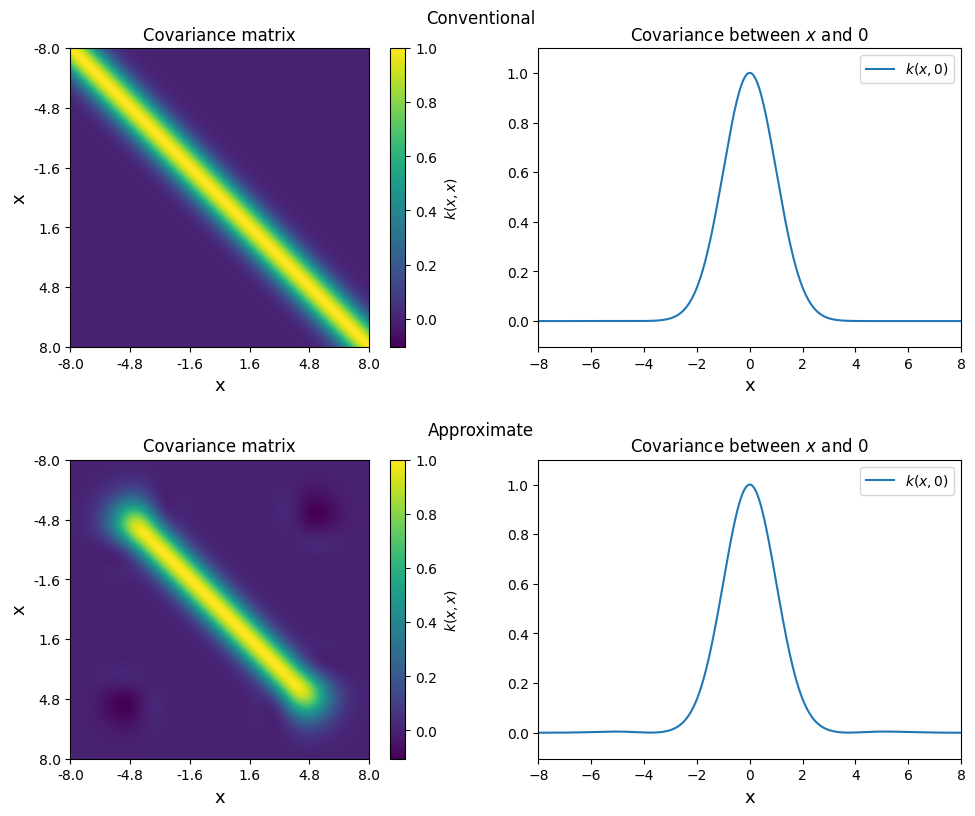

In [16]:
with torch.no_grad():
    conv_f_train = conv_model(train_x)
    conv_train_covar = conv_f_train.covariance_matrix

    approx_f_train = approx_model(train_x)
    approx_train_covar = approx_f_train.covariance_matrix

    rmse = torch.sqrt(torch.mean((conv_train_covar - approx_train_covar)**2))
    print("\nRMSE:", rmse)

    # plot resulting covariance matrix
    fig = plt.figure(figsize=(12, 8))
    subfigs = fig.subfigures(2, 1, hspace=0.06)
    subfigs[0].suptitle("Conventional")
    subfigs[1].suptitle("Approximate")
    vmin = torch.min(torch.cat((conv_train_covar, approx_train_covar))).item()
    vmax = torch.max(torch.cat((conv_train_covar, approx_train_covar))).item()
    for row, covar in enumerate([conv_train_covar.to('cpu'), approx_train_covar.to('cpu')]):
        ax1, ax2 = subfigs[row].subplots(1, 2)

        im = ax1.imshow(covar.numpy(), cmap=plt.colormaps['viridis'], vmin=vmin, vmax=vmax)
        cbar = plt.colorbar(im, ax=ax1)
        cbar.ax.set_ylabel('$k(x,x)$', fontsize=10)
        ax1.set_title("Covariance matrix")
        ax1.set_xlabel('x', fontsize=13)
        ax1.set_ylabel('x', fontsize=13)
        ax1.set_xticks(np.linspace(0, nb_training_points - 1, min(nb_training_points, 6)))
        ax1.set_yticks(np.linspace(0, nb_training_points - 1, min(nb_training_points, 6)))
        ax1.set_xticklabels(np.round(np.linspace(-abs_limit, abs_limit, min(nb_training_points, 6)), 2))
        ax1.set_yticklabels(np.round(np.linspace(-abs_limit, abs_limit, min(nb_training_points, 6)), 2))
        ax1.grid(False)

        ax2.plot(train_x.to('cpu').numpy(), covar.numpy()[:,nb_training_points // 2], label='$k(x,0)$')
        ax2.set_xlabel('x', fontsize=13)
        ax2.set_title('Covariance between $x$ and $0$')
        ax2.set_xlim([-abs_limit, abs_limit])
        ax2.set_ylim([vmin, 1.1])
        ax2.legend(loc=1)